In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from window_generator import WindowGenerator
from seaborn import violinplot

np.set_printoptions(precision = 4)

2023-01-26 18:52:00.921018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737", rank_range = None) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        if rank_range != None:
            res = res.loc[(res["rank"] >= rank_range[0]) & (res["rank"] <= rank_range[1])]

        #Aggregating for mean household prices per day 
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [3]:
# def dataGenerator(post_code, batch_size, window, norm_layer):

#     while True:
#         for consRange in consRanges[0:3]:
#             df = queryRangePostCode(household, consRange, rank_range=(6,10))
#             df = df.join(market[["d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
#             df = df.drop(["2022-10-14", "2022-10-15"])
#             df = norm_layer(df)
#             df = window.make_dataset(df)

            
#             yield (df)

In [4]:
path_clean_power = "./data/master_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str, "rank": np.float16}
usecols = [name for name, _ in dtypes.items()]

household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)

market.set_index("date", inplace = True)
market.interpolate(method = "time", axis = 0, inplace = True)
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])
postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [5]:
postCodes

array(['51103', '51381', '51469', '22159', '14480', '76137', '90459',
       '26133', '33613', '81737', '97084', '47441', '18109', '19061',
       '28259', '39108', '99089', '3046', '12627', '21423', '9130',
       '34125', '57072', '59071', '24109', '37085', '60439', '23558',
       '33102', '41462', '44866', '27578', '31137', '38226', '45899',
       '46049', '47137', '56070', '58636', '75181', '31789', '8058',
       '33332', '46238', '47798', '55118', '53229', '1309', '4229',
       '6844', '7743', '8523', '17489', '22844', '30419', '38120',
       '38448', '38640', '40625', '41751', '42719', '44575', '49082',
       '52066', '65197', '66113', '67063', '68309', '69126', '71638',
       '72108', '78054', '79110', '93049', '48429', '41238', '42897',
       '48161', '54294', '58135', '58452', '63069', '67663', '70499',
       '72762', '74078', '85055', '86179', '90763', '44625', '6110',
       '7549', '42277', '45355', '45481', '45665', '89075', '64289',
       '27753', '44339'], dtyp

In [177]:
df = queryRangePostCode(household, 3500, "47137", rank_range=[6,10])
input = df.join(market[["d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [178]:
# adapts to dataset which is not training DS!!
norm_layer = tf.keras.layers.Normalization(axis = 1)
norm_layer.adapt(input.to_numpy())

In [ ]:
norm_input = norm_layer(input.to_numpy())
norm_input = pd.DataFrame(norm_input, columns = input.columns, index = input.index)

# Baseline

In [161]:
shift = 1
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=shift,
    label_columns=['price_kwh'], train_df=norm_input, val_df=norm_input)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price_kwh']

In [162]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [163]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

13/13 [==============================] - 0s 7ms/step - loss: 0.0163 - mean_absolute_percentage_error: 28.7275


In [164]:
input_width = 15

In [165]:
my_window = WindowGenerator(
    input_width=input_width,
    label_width=1,
    shift=shift,
    label_columns=['price_kwh'],
    train_df=norm_input,
    val_df=norm_input)

my_window

Total window size: 16
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [15]
Label column name(s): ['price_kwh']

In [166]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])


In [167]:
multi_step_dense_model = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='sigmoid'),
    tf.keras.layers.Dense(units=64, activation='sigmoid'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
multi_step_dense_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [168]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=2,
                                                    mode='min',
                                                    verbose = 1)

epochs = 5

In [169]:
training_ranges = consRanges[(consRanges>=2000) & (consRanges<=8000)]
training_ranges

array([3500, 2800, 2000, 2400, 7500, 7800, 8000, 7000, 2500, 3000, 4000,
       4500, 5000, 6500, 4250, 3600, 6000, 5500, 5600], dtype=int32)

In [170]:
for consRange in training_ranges:
    print(consRange, end = " ")
    df = queryRangePostCode(household, consRange, post_code = "81737", rank_range=(6,10))
    df = df.join(market[["d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
    df = df.drop(["2022-10-14", "2022-10-15"])
    df = norm_layer(df)
    dataset = my_window.make_dataset(df)
    lstm_model.fit(dataset, epochs = epochs, callbacks= early_stopping, verbose = 0, shuffle=True)
    multi_step_dense_model.fit(dataset, epochs = epochs, callbacks = early_stopping, verbose = 0, shuffle=True)

3500 2800 2000 Epoch 3: early stopping
2400 7500 Epoch 4: early stopping
7800 8000 Epoch 3: early stopping
Epoch 5: early stopping
7000 Epoch 3: early stopping
2500 Epoch 5: early stopping
3000 Epoch 4: early stopping
Epoch 3: early stopping
4000 4500 Epoch 4: early stopping
5000 Epoch 3: early stopping
Epoch 3: early stopping
6500 4250 Epoch 3: early stopping
3600 6000 5500 Epoch 3: early stopping
5600 Epoch 3: early stopping


In [171]:
def predict_with_date(self: tf.keras.Model, window: WindowGenerator, df) -> pd.DataFrame:
    model_input = window.make_dataset(df)
    predictions = self.predict(model_input, verbose = 0)
    dates = df.index[slice(window.total_window_size-1,None)]
    return pd.Series(predictions[:,predictions.shape[1]-1].flatten(), index = dates)

tf.keras.Model.predict_with_date = predict_with_date

def inverse_norm_price_p_kwh(df):
    sd = np.sqrt(norm_layer.variance[0,0])
    mean = norm_layer.mean[0,0]
    return df*sd + mean

def plot(self, window: WindowGenerator, df: pd.DataFrame):
    fig = plt.figure()
    plt.plot(
        inverse_norm_price_p_kwh(
            baseline.predict_with_date(window = window, df = df)), 
                                       label = "Baseline")
    
    plt.plot(
        inverse_norm_price_p_kwh(
        self.predict_with_date(window = window, df = df)), 
                                        label = "Predictions")
    
    plt.plot(
        inverse_norm_price_p_kwh(df["price_kwh"]), 
                                    label = "Original")
    
    plt.xticks(rotation = 45)
    plt.legend()

tf.keras.Model.plot = plot

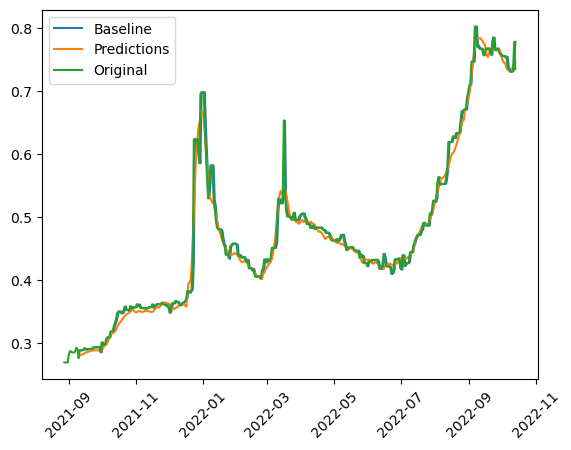

In [181]:
lstm_model.plot(window = my_window, df = norm_input)

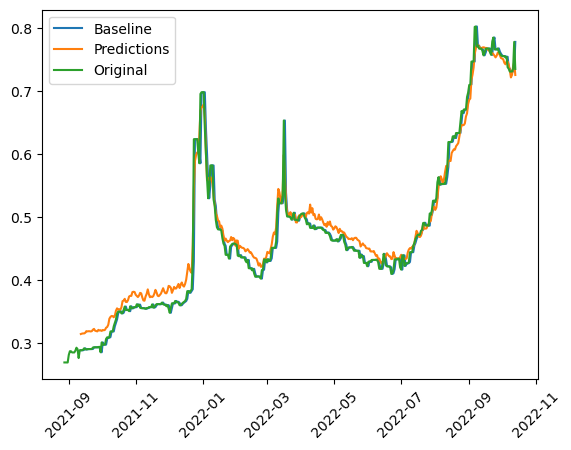

In [182]:
multi_step_dense_model.plot(window = my_window, df = norm_input)

In [179]:
dataset = my_window.make_dataset(norm_input)
val_performance["lstm_model"] = lstm_model.evaluate(dataset)
val_performance["multi_step_dense_model"] = multi_step_dense_model.evaluate(dataset)

13/13 [==============================] - 0s 11ms/step - loss: 0.0201 - mean_absolute_percentage_error: 54.2646


In [175]:
val_performance

{'Baseline': [0.016327418386936188, 28.727497100830078],
 'lstm_model': [0.01340281218290329, 68.59217071533203],
 'multi_step_dense_model': [0.021105321124196053, 178.9551239013672]}

In [180]:
val_performance

{'Baseline': [0.016327418386936188, 28.727497100830078],
 'lstm_model': [0.013421465642750263, 37.461341857910156],
 'multi_step_dense_model': [0.020142219960689545, 54.2646369934082]}